In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub

In [ ]:
from torch.utils.data import Dataset

class VoxelDataset(Dataset):
    def __init__(self, voxel_paths, labels):
        self.data = voxel_paths
        self.labels = labels

    def __getitem__(self, index):
        vox = np.load(self.data[index])  # or call mesh_to_voxel here
        label = self.labels[index]
        return torch.tensor(vox).unsqueeze(0), torch.tensor(label)

    def __len__(self):
        return len(self.data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

X = np.load('/content/drive/MyDrive/Deep2025/X_voxel_oriented.npy')
y_class = np.load('/content/drive/MyDrive/Deep2025/y_class_oriented.npy')
y_orientation = np.load('/content/drive/MyDrive/Deep2025/y_orientation_oriented.npy')

print("✅ Done:")
print("🔸 X:", X.shape)
print("🔸 y_class:", y_class.shape)
print("🔸 y_orientation:", y_orientation.shape)

Mounted at /content/drive
✅ Done:
🔸 X: (47892, 32, 32, 32, 1)
🔸 y_class: (47892,)
🔸 y_orientation: (47892,)


In [ ]:
from sklearn.model_selection import train_test_split

# First split: 80% train_val, 20% test
X_train_val, X_test, y_class_train_val, y_class_test, y_ori_train_val, y_ori_test = train_test_split(
    X, y_class, y_orientation,
    test_size=0.2,
    stratify=y_class,
    random_state=42
)

# Second split: 80% train, 20% val (from the 80% that remained)
X_train, X_val, y_class_train, y_class_val, y_ori_train, y_ori_val = train_test_split(
    X_train_val, y_class_train_val, y_ori_train_val,
    test_size=0.2,
    stratify=y_class_train_val,
    random_state=42
)

In [ ]:
num_classes = len(np.unique(y_class))
num_orientations = len(np.unique(y_orientation))
print("Number of classes:", num_classes)
print("Number of orientations:", num_orientations)

Number of classes: 10
Number of orientations: 12


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define input shape
input_voxel = Input(shape=(32, 32, 32, 1))

# Block 1
x = Conv3D(32, 3, padding='same')(input_voxel)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D()(x)
x = Dropout(0.3)(x)

# Block 2
x = Conv3D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D()(x)
x = Dropout(0.3)(x)

# Block 3
x = Conv3D(128, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D()(x)
x = Dropout(0.4)(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers (must be connected to previous layer x)
output_class = Dense(num_classes, activation='softmax', name='class')(x)
output_orientation = Dense(num_orientations, activation='softmax', name='orientation')(x)

# Define model
model = Model(inputs=input_voxel, outputs=[output_class, output_orientation])

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'class': 'sparse_categorical_crossentropy',
        'orientation': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'class': 0.5,
        'orientation': 0.5
    },
    metrics={
        'class': 'accuracy',
        'orientation': 'accuracy'
    }
)

# Callbacks to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train,
    {'class': y_class_train, 'orientation': y_ori_train},
    validation_data=(X_val, {'class': y_class_val, 'orientation': y_ori_val}),
    epochs=40,
    batch_size=8,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/40
3832/3832 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - class_accuracy: 0.2578 - class_loss: 2.2861 - loss: 2.4880 - orientation_accuracy: 0.0866 - orientation_loss: 2.6900 - val_class_accuracy: 0.3530 - val_class_loss: 1.9174 - val_loss: 2.2024 - val_orientation_accuracy: 0.0831 - val_orientation_loss: 2.4874 - learning_rate: 0.0010
Epoch 2/40
3832/3832 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - class_accuracy: 0.2741 - class_loss: 1.9689 - loss: 2.2302 - orientation_accuracy: 0.0820 - orientation_loss: 2.4916 - val_class_accuracy: 0.3869 - val_class_loss: 1.7343 - val_loss: 2.1112 - val_orientation_accuracy: 0.0822 - val_orientation_loss: 2.4881 - learning_rate: 0.0010
Epoch 3/40
3832/3832 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - class_accuracy: 0.2775 - class_loss: 1.9569 - loss: 2.2237 - orientation_accuracy: 0.0833 - orientation_loss: 2.4905 - val_class_accuracy: 0.3902 - val_class_loss: 1.7289 - val_loss: 2.1074 - val_orientation_accuracy: 0.0860 - val_orientation_loss: 2.4859 - learning_ra

In [ ]:
model.save("voxelnet_or_model.h5")
model.save("voxelnet_or_model.keras")

In [ ]:
model.evaluate(X_test, {'class': y_class_test, 'orientation': y_ori_test})

300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - class_accuracy: 0.9781 - class_loss: 0.0630 - loss: 0.1828 - orientation_accuracy: 0.8521 - orientation_loss: 0.3025


[0.18933162093162537,
 0.06862759590148926,
 0.30979403853416443,
 0.9759891629219055,
 0.8557260632514954]

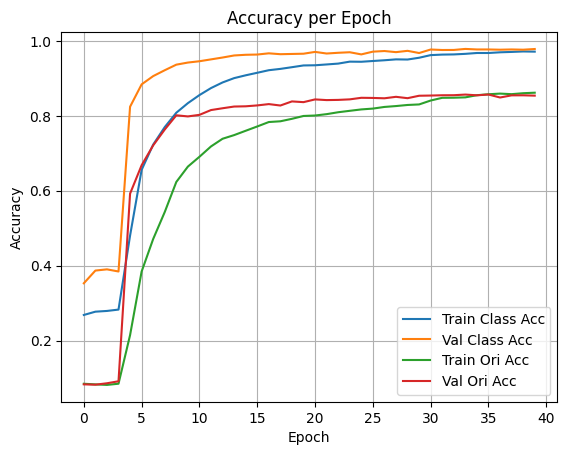

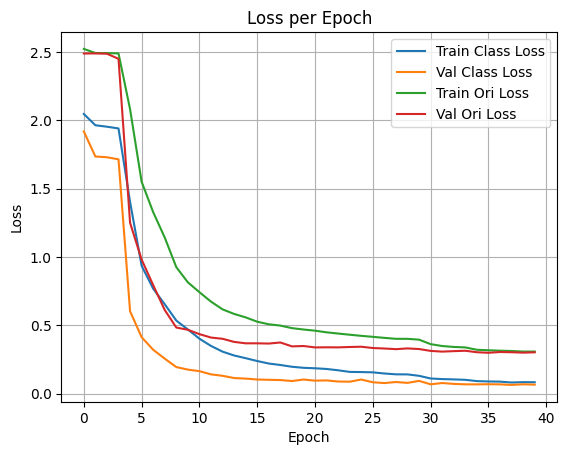

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure()
plt.plot(history.history['class_accuracy'], label='Train Class Acc')
plt.plot(history.history['val_class_accuracy'], label='Val Class Acc')
plt.plot(history.history['orientation_accuracy'], label='Train Ori Acc')
plt.plot(history.history['val_orientation_accuracy'], label='Val Ori Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.figure()
plt.plot(history.history['class_loss'], label='Train Class Loss')
plt.plot(history.history['val_class_loss'], label='Val Class Loss')
plt.plot(history.history['orientation_loss'], label='Train Ori Loss')
plt.plot(history.history['val_orientation_loss'], label='Val Ori Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Auto-extract class names from unique labels
import numpy as np

unique_labels = np.unique(y_class)
label_map = {idx: f"class_{idx}" for idx in unique_labels}

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


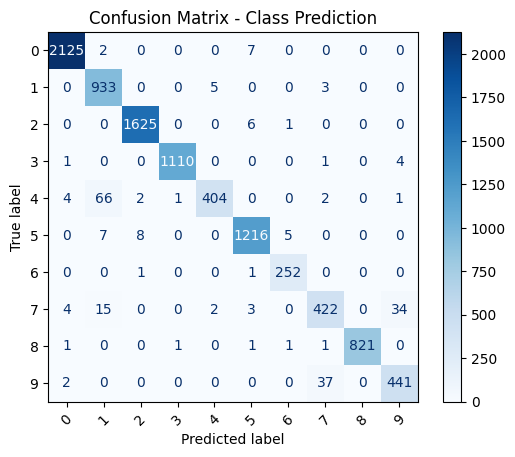

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on test set
pred_class, pred_orientation = model.predict(X_test)
pred_class_labels = np.argmax(pred_class, axis=1)

# Plot confusion matrix for class
cm = confusion_matrix(y_class_test, pred_class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Class Prediction")
plt.grid(False)
plt.show()

In [ ]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

